In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import torch
from torch.utils.data import Dataset
from collections import defaultdict
import pandas as pd

class TransliterationDataset(Dataset):
    def __init__(self, pairs, input_vocab, output_vocab):
        self.pairs = pairs
        self.input_vocab = input_vocab
        self.output_vocab = output_vocab
        self.sos = output_vocab['<sos>']
        self.eos = output_vocab['<eos>']

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        source, target = self.pairs[idx]
        input_ids = [self.input_vocab[c] for c in source]
        target_ids = [self.sos] + [self.output_vocab[c] for c in target] + [self.eos]
        return torch.tensor(input_ids), torch.tensor(target_ids)

def build_vocab(pairs):
    input_chars = set()
    output_chars = set()
    for source, target in pairs:
        if isinstance(source, str) and isinstance(target, str):
            input_chars.update(source)
            output_chars.update(target)

    input_vocab = {c: i + 1 for i, c in enumerate(sorted(input_chars))}
    input_vocab['<pad>'] = 0
    output_vocab = {c: i + 3 for i, c in enumerate(sorted(output_chars))}
    output_vocab.update({'<pad>': 0, '<sos>': 1, '<eos>': 2})

    return input_vocab, output_vocab

def collate_fn(batch):
    inputs, targets = zip(*batch)
    input_lens = [len(seq) for seq in inputs]
    target_lens = [len(seq) for seq in targets]

    inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
    targets_padded = torch.nn.utils.rnn.pad_sequence(targets, batch_first=True, padding_value=0)

    return inputs_padded, targets_padded, input_lens, target_lens

def load_pairs(path):
    df = pd.read_csv(path, sep="\t", header=None, names=["target", "source", "count"], dtype=str)
    df.dropna(subset=["source", "target"], inplace=True)
    return list(zip(df["source"], df["target"]))


In [ ]:
import torch
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, input_size, embed_size, hidden_size, num_layers, cell_type, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(input_size, embed_size, padding_idx=0)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        rnn_class = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}[cell_type]
        self.rnn = rnn_class(embed_size, hidden_size, num_layers, 
                             dropout=dropout if num_layers > 1 else 0,
                             batch_first=True)

    def forward(self, x, lengths):
        embedded = self.embedding(x)
        packed = nn.utils.rnn.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        outputs, hidden = self.rnn(packed)
        return outputs, hidden

class Decoder(nn.Module):
    def __init__(self, output_size, embed_size, hidden_size, num_layers, cell_type, dropout=0.2):
        super().__init__()
        self.embedding = nn.Embedding(output_size, embed_size, padding_idx=0)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.cell_type = cell_type
        rnn_class = {'RNN': nn.RNN, 'GRU': nn.GRU, 'LSTM': nn.LSTM}[cell_type]
        self.rnn = rnn_class(embed_size, hidden_size, num_layers, 
                             dropout=dropout if num_layers > 1 else 0,
                             batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, input_token, hidden):
        # input_token: (batch,) -> (batch, 1)
        embedded = self.embedding(input_token.unsqueeze(1))  # (batch, 1, embed)
        output, hidden = self.rnn(embedded, hidden)
        output = self.fc(output.squeeze(1))  # (batch, output_size)
        return output, hidden

    def beam_search_decode(self, encoder_outputs, encoder_hidden, start_token_id, end_token_id, beam_width=5, max_len=50):
        """
        Beam search decoding for the decoder.
    
        Args:
            encoder_outputs: outputs from encoder
            encoder_hidden: encoder final hidden state
            beam_width: beam size
            max_len: maximum length of decoded sequence
            start_token_id: id of start-of-sequence token
            end_token_id: id of end-of-sequence token
    
        Returns:
            best sequence (list of token IDs)
        """
    
        # Each beam is a tuple (sequence, hidden_state, score)
        beams = [([start_token_id], encoder_hidden, 0.0)]  # score is log prob sum
    
        for _ in range(max_len):
            new_beams = []
            for seq, hidden, score in beams:
                if seq[-1] == end_token_id:
                    # Already ended, keep as is
                    new_beams.append((seq, hidden, score))
                    continue
                
                # Create a batch of size 1 with the current token
                input_token = torch.tensor([seq[-1]], device=hidden[0].device if isinstance(hidden, tuple) else hidden.device)
    
                # Forward one step in decoder
                output, new_hidden = self.forward(input_token, hidden)
    
                # Get log probabilities
                log_probs = torch.log_softmax(output, dim=-1)  # (1, vocab_size)
    
                # Get top k tokens and scores
                top_log_probs, top_indices = torch.topk(log_probs, beam_width)
    
                for i in range(beam_width):
                    next_token = top_indices[0, i].item()
                    next_score = score + top_log_probs[0, i].item()
                    new_seq = seq + [next_token]
                    new_beams.append((new_seq, new_hidden, next_score))
    
            # Keep top beam_width sequences
            beams = sorted(new_beams, key=lambda x: x[2], reverse=True)[:beam_width]
    
            # If all beams ended with EOS token, stop early
            if all(seq[-1] == end_token_id for seq, _, _ in beams):
                break
    
        # Return the sequence with the highest score
        best_seq = beams[0][0]
        return best_seq

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, cell_type):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.cell_type = cell_type

    def _convert_encoder_hidden_to_decoder_hidden(self, encoder_hidden):
        """
        Convert encoder hidden state to the format expected by decoder
        Handles different number of layers between encoder and decoder
        """
        # For LSTM, encoder_hidden is a tuple (hidden_state, cell_state)
        if self.cell_type == 'LSTM':
            h, c = encoder_hidden
            
            # If encoder and decoder have different number of layers
            encoder_layers = h.size(0)
            decoder_layers = self.decoder.num_layers
            
            if encoder_layers != decoder_layers:
                # Option 1: Use only the last layers of encoder if it has more layers
                if encoder_layers > decoder_layers:
                    h = h[-decoder_layers:]
                    c = c[-decoder_layers:]
                # Option 2: Repeat the last layer of encoder if decoder has more layers
                else:
                    h_extra = h[-1:].repeat(decoder_layers - encoder_layers, 1, 1)
                    c_extra = c[-1:].repeat(decoder_layers - encoder_layers, 1, 1)
                    h = torch.cat([h, h_extra], dim=0)
                    c = torch.cat([c, c_extra], dim=0)
            
            return (h, c)
        
        # For RNN and GRU, encoder_hidden is just the hidden state
        else:
            h = encoder_hidden
            
            # If encoder and decoder have different number of layers
            encoder_layers = h.size(0)
            decoder_layers = self.decoder.num_layers
            
            if encoder_layers != decoder_layers:
                # Option 1: Use only the last layers of encoder if it has more layers
                if encoder_layers > decoder_layers:
                    h = h[-decoder_layers:]
                # Option 2: Repeat the last layer of encoder if decoder has more layers
                else:
                    h_extra = h[-1:].repeat(decoder_layers - encoder_layers, 1, 1)
                    h = torch.cat([h, h_extra], dim=0)
            
            return h

    def forward(self, src, src_lens, tgt=None, teacher_forcing_ratio=0.5):
        """
        Args:
            src: (batch, src_len)
            src_lens: list of original lengths before padding
            tgt: (batch, tgt_len)
        Returns:
            outputs: (batch, tgt_len, vocab_size)
        """
        batch_size = src.size(0)
        device = src.device
        tgt_len = tgt.size(1)
        vocab_size = self.decoder.fc.out_features

        outputs = torch.zeros(batch_size, tgt_len, vocab_size).to(device)

        # Get encoder outputs and hidden state
        encoder_outputs, encoder_hidden = self.encoder(src, src_lens)
        
        # Convert encoder hidden state to the format expected by decoder
        hidden = self._convert_encoder_hidden_to_decoder_hidden(encoder_hidden)

        input_token = tgt[:, 0]  # <sos>

        for t in range(1, tgt_len):
            output, hidden = self.decoder(input_token, hidden)
            outputs[:, t] = output
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input_token = tgt[:, t] if teacher_force else top1

        return outputs

    def beam_search_decode(self, src, src_lens, start_token_id, end_token_id, beam_width=5, max_len=50):
        # Encode source sequence
        encoder_outputs, encoder_hidden = self.encoder(src, src_lens)
        
        # Convert encoder hidden state to the format expected by decoder
        decoder_hidden = self._convert_encoder_hidden_to_decoder_hidden(encoder_hidden)
    
        # Use decoder beam search
        return self.decoder.beam_search_decode(
            encoder_outputs, decoder_hidden,
            beam_width=beam_width, max_len=max_len,
            start_token_id=start_token_id, end_token_id=end_token_id
        )

In [ ]:
import torch
from tqdm import tqdm

def accuracy(preds, targets, pad_idx=0):
    pred_tokens = preds.argmax(dim=-1)
    # print("Prediction", pred_tokens)
    correct = ((pred_tokens == targets) & (targets != pad_idx)).sum().item()
    total = (targets != pad_idx).sum().item()
    return correct / total

def train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss, total_acc = 0, 0

    for src, tgt, src_lens, tgt_lens in tqdm(loader, desc="Training"):
        src, tgt = src.to(device), tgt.to(device)
        optimizer.zero_grad()
        output = model(src, src_lens, tgt)
        loss = criterion(output[:, 1:].reshape(-1, output.size(-1)), tgt[:, 1:].reshape(-1))
        acc = accuracy(output[:, 1:], tgt[:, 1:])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        total_acc += acc

    return total_loss / len(loader), total_acc / len(loader)

@torch.no_grad()
def evaluate(model, loader, criterion, device, start_token_id, end_token_id, beam_width=None, max_len=50):
    model.eval()
    total_loss, total_acc = 0, 0

    for src, tgt, src_lens, tgt_lens in tqdm(loader, desc="Evaluating"):
        src, tgt = src.to(device), tgt.to(device)

        batch_size = src.size(0)

        if beam_width is not None and batch_size == 1:
            pred_seq = model.beam_search_decode(src, src_lens, start_token_id, end_token_id, beam_width=beam_width, max_len=max_len)
            pred_tensor = torch.tensor(pred_seq, device=device).unsqueeze(0)  # (1, seq_len)
            tgt_tensor = tgt[:, 1:]

            acc = (pred_tensor[:, :tgt_tensor.size(1)] == tgt_tensor[:, :pred_tensor.size(1)]).float().mean().item()
            loss = torch.tensor(0.0)  # Skip loss calculation for beam search for now

            total_loss += loss.item()
            total_acc += acc

        else:
            output = model(src, src_lens, tgt, teacher_forcing_ratio=0.0)
            loss = criterion(output[:, 1:].reshape(-1, output.size(-1)), tgt[:, 1:].reshape(-1))
            acc = accuracy(output[:, 1:], tgt[:, 1:])
            total_loss += loss.item()
            total_acc += acc

    return total_loss / len(loader), total_acc / len(loader)

In [ ]:
# from train import train, evaluate
# from dataset import load_pairs, build_vocab, TransliterationDataset, collate_fn
# import wandb
# wandb.init(project="transliteration-seq2seq", config={
#     "embed_size": 64,
#     "hidden_size": 128,
#     "num_layers": 1,
#     "cell_type": "LSTM",
#     "batch_size": 32,
#     "epochs": 10,
#     "lr": 0.001,
#     "dropout": 0.2
# })
import wandb
import json
def generate_run_name(config):
    """Create a descriptive run name for wandb."""
    return (
        f"bs{config.get('batch_size')}_lr{config.get('lr'):.0e}_"
        f"emb{config.get('embed_size')}_hid{config.get('hidden_size')}_"
        f"layers{config.get('num_layers')}_{config.get('cell_type')}_"
        f"drop{int(config.get('dropout') * 100)}_beam{config.get('beam_width')}_"
        f"ep{config.get('epochs')}"
    )

def run_sweep():
    run = wandb.init()
    config = wandb.config
    run.name = generate_run_name(config)
    # === Load Data ===
    train_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.train.tsv")
    val_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.dev.tsv")
    test_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.test.tsv")
    
    # === Build vocab from training ===
    input_vocab, output_vocab = build_vocab(train_pairs)
    pad_idx = output_vocab['<pad>']
    SOS_token_idx = output_vocab['<sos>']
    EOS_token_idx = output_vocab['<eos>']
    
    # === Datasets ===
    train_dataset = TransliterationDataset(train_pairs, input_vocab, output_vocab)
    val_dataset = TransliterationDataset(val_pairs, input_vocab, output_vocab)
    test_dataset = TransliterationDataset(test_pairs, input_vocab, output_vocab)
    
    # === Dataloaders ===
    from torch.utils.data import DataLoader
    
    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)
    
    # === Model, Optimizer, Loss ===
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    encoder = Encoder(len(input_vocab), config.embed_size, config.hidden_size, config.num_layers_encoder, config.cell_type, config.dropout)
    decoder = Decoder(len(output_vocab), config.embed_size, config.hidden_size, config.num_layers_decoder, config.cell_type, config.dropout)
    model = Seq2Seq(encoder, decoder, config.cell_type).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
    criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_idx)

    best_val_acc = 0.0
    best_config = None
    # === Train and validate ===
    for epoch in range(config.epochs):
        train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device, SOS_token_idx, EOS_token_idx, beam_width=config.beam_width)
    
        wandb.log({
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "epoch": epoch + 1
        })

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            best_config = dict(config)
            with open('best_config.json', 'w') as f:
                json.dump(best_config, f, indent=4)
            wandb.save('best_model.pth')
            wandb.save('best_config.json')
    
        print(f"[Epoch {epoch+1}] Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
    
    # # === Final Evaluation on Test Set ===
    # test_loss, test_acc = evaluate(model, test_loader, criterion, device, beam_width=config.beam_width)
    # wandb.log({"test_loss": test_loss, "test_acc": test_acc})
    # print(f"\n[Test Evaluation] Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")


In [ ]:
!wandb login 47aa32aca06bea662b4b8c2246cefcb55bd15dab

In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'embed_size': {'values': [16, 32, 64, 256]},
        'hidden_size': {'values': [16, 32, 64, 256]},
        'num_layers_encoder': {'values': [1, 2, 3]},
        'num_layers_decoder': {'values': [1, 2, 3]},
        'cell_type': {'values': ['RNN', 'GRU', 'LSTM']},
        'dropout': {'values': [0.2, 0.3]},
        'lr': {'min': 0.0001, 'max': 0.01},
        'batch_size': {'values': [32, 64]},
        'epochs': {'value': 10},
        'beam_width': {'values': [1, 3, 5, 10]}  # added beam_width here
    }
}
sweep_id = wandb.sweep(sweep_config, project="dakshina-transliteration")
wandb.agent(sweep_id, function=run_sweep)

In [ ]:
# import torch
# import wandb
# from torch.utils.data import DataLoader
# # from dataset import load_pairs, build_vocab, TransliterationDataset, collate_fn
# # from model import Encoder, Decoder, Seq2Seq
# # from train import train

# wandb.init(project="transliteration-seq2seq", config={
#     "embed_size": 64,
#     "hidden_size": 128,
#     "num_layers": 1,
#     "cell_type": "LSTM",
#     "batch_size": 32,
#     "epochs": 10,
#     "lr": 0.001
# })

# config = wandb.config

# # Load data
# pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.train.tsv")
# input_vocab, output_vocab = build_vocab(pairs)
# dataset = TransliterationDataset(pairs, input_vocab, output_vocab)
# loader = DataLoader(dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)

# # Model
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# encoder = Encoder(len(input_vocab), config.embed_size, config.hidden_size, config.num_layers, config.cell_type)
# decoder = Decoder(len(output_vocab), config.embed_size, config.hidden_size, config.num_layers, config.cell_type)
# model = Seq2Seq(encoder, decoder, config.cell_type).to(device)

# # Optimizer and Loss
# optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
# criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

# # Training loop
# for epoch in range(config.epochs):
#     loss, acc = train(model, loader, optimizer, criterion, output_vocab, device)
#     wandb.log({"loss": loss, "accuracy": acc, "epoch": epoch})
#     print(f"Epoch {epoch+1}: Loss={loss:.4f}, Accuracy={acc:.4f}")


In [ ]:
import os
import torch

def save_predictions(model, dataloader, output_file, pad_idx, idx2label, SOS_token_idx, EOS_token_idx, device, beam_width=1):
    """
    Save predictions from the model to a text file, decoding output sequences to strings.
    """
    model.eval()
    predictions = []

    with torch.no_grad():
        for batch in dataloader:
            src_batch = batch[0]  # We only need the inputs
            src_batch = src_batch.to(device)

            # Generate predictions (returns List[List[int]])
            output_sequences = model.predict(
                src_batch,
                SOS_token_idx=SOS_token_idx,
                EOS_token_idx=EOS_token_idx,
                device=device,
                beam_width=beam_width
            )

            for seq in output_sequences:
                # Stop at EOS and skip PAD/SOS/EOS
                if EOS_token_idx in seq:
                    seq = seq[:seq.index(EOS_token_idx)]
                decoded = ''.join([idx2label[idx] for idx in seq if idx not in {pad_idx, SOS_token_idx, EOS_token_idx}])
                predictions.append(decoded)

    # Save to file
    os.makedirs(os.path.dirname(output_file), exist_ok=True)
    with open(output_file, 'w', encoding='utf-8') as f:
        for line in predictions:
            f.write(line + '\n')

    print(f"✅ Saved {len(predictions)} predictions to: {output_file}")


In [ ]:
import torch
import random
import pandas as pd
import os
from colorama import Fore, Style, init
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageDraw, ImageFont
from io import BytesIO
import base64
import wandb
from tqdm import tqdm

def display_model_predictions(model, test_loader, input_vocab, output_vocab, device, 
                              start_token_id, end_token_id, beam_width=None, num_samples=10,
                              max_len=50, save_all=True, output_dir="predictions_vanilla"):
    """
    Display sample predictions from the test set and save all predictions to a file.
    
    Args:
        model: The trained model for inference
        test_loader: DataLoader containing test data
        input_vocab: Dictionary mapping characters to indices for input
        output_vocab: Dictionary mapping characters to indices for output
        device: Device to run inference on
        start_token_id: Index of the start token
        end_token_id: Index of the end token
        beam_width: Width for beam search (None for greedy)
        num_samples: Number of samples to display
        max_len: Maximum length for predictions
        save_all: Whether to save all predictions to a file
        output_dir: Directory to save predictions to
    """
    # Ensure model is in eval mode
    model.eval()
    
    # Create reverse vocabulary maps
    input_idx2char = {idx: char for char, idx in input_vocab.items()}
    output_idx2char = {idx: char for char, idx in output_vocab.items()}
    
    # Initialize colorama for terminal colors
    init()
    
    # For storing all results
    all_results = []
    display_samples = []
    
    # Generate predictions
    with torch.no_grad():
        for batch_idx, (src, tgt, src_lens, tgt_lens) in enumerate(tqdm(test_loader, desc="Generating predictions")):
            src = src.to(device)
            tgt = tgt.to(device)
            batch_size = src.size(0)
            
            for i in range(batch_size):
                # Get input sequence (remove padding)
                input_seq = src[i, :src_lens[i]].cpu().numpy()
                # Get target sequence (remove padding, SOS, and EOS)
                target_seq = tgt[i, 1:tgt_lens[i]-1].cpu().numpy()
                
                # Convert indices to characters
                input_str = ''.join([input_idx2char[idx] for idx in input_seq])
                target_str = ''.join([output_idx2char[idx] for idx in target_seq])
                
                # Generate prediction using beam search if specified
                if beam_width is not None:
                    pred_indices = model.beam_search_decode(
                        src[i:i+1], src_lens[i:i+1], 
                        start_token_id, end_token_id, 
                        beam_width=beam_width, max_len=max_len
                    )
                else:
                    # Greedy decoding
                    output = model(src[i:i+1], src_lens[i:i+1], tgt[i:i+1], teacher_forcing_ratio=0)
                    pred_indices = output[0].argmax(dim=-1).cpu().numpy()
                    # Remove SOS token if present
                    if pred_indices[0] == start_token_id:
                        pred_indices = pred_indices[1:]
        
                pred_chars = []
                for idx in pred_indices:
                    # Skip start token and end token
                    if idx == start_token_id or idx == end_token_id:
                        continue
                    pred_chars.append(output_idx2char.get(idx, '?'))
                prediction = ''.join(pred_chars)
                
                # Calculate character-level accuracy
                min_len = min(len(target_str), len(prediction))
                correct_chars = sum(1 for i in range(min_len) if target_str[i] == prediction[i])
                char_accuracy = correct_chars / len(target_str) if len(target_str) > 0 else 0
                
                # Check if prediction matches target exactly
                exact_match = prediction == target_str
                
                # Store result
                result = {
                    'input': input_str,
                    'target': target_str,
                    'prediction': prediction,
                    'char_accuracy': char_accuracy,
                    'exact_match': exact_match
                }
                all_results.append(result)
                
                # If we haven't collected enough samples yet, add this one
                if len(display_samples) < num_samples:
                    display_samples.append(result)

    # Create output directory if it doesn't exist
    if save_all and output_dir:
        os.makedirs(output_dir, exist_ok=True)
        
        # Save all predictions to CSV
        results_df = pd.DataFrame(all_results)
        csv_path = os.path.join(output_dir, "test_predictions.csv")
        results_df.to_csv(csv_path, index=False)
        print(f"Saved all predictions to {csv_path}")
    
    # Display sample predictions in a creative way
    print("\n" + "="*80)
    print(f"{Fore.CYAN}💫 TRANSLITERATION MODEL PREDICTIONS 💫{Style.RESET_ALL}")
    print("="*80)
    
    # Compute overall statistics
    exact_matches = sum(1 for r in all_results if r['exact_match'])
    avg_char_acc = sum(r['char_accuracy'] for r in all_results) / len(all_results)
    
    print(f"{Fore.YELLOW}📊 OVERALL STATS:{Style.RESET_ALL}")
    print(f"  Total Samples: {len(all_results)}")
    print(f"  Exact Match Accuracy: {exact_matches/len(all_results):.2%}")
    print(f"  Avg. Character-Level Accuracy: {avg_char_acc:.2%}")
    print("-"*80)
    
    # print(f"{Fore.GREEN}🎯 SAMPLE PREDICTIONS ({num_samples}):{Style.RESET_ALL}")
    for i, sample in enumerate(display_samples):
        print(f"\n{Fore.BLUE}Example #{i+1}:{Style.RESET_ALL}")
        print(f"  {Fore.WHITE}Input (Latin): {Style.RESET_ALL}{sample['input']}")
        print(f"  {Fore.MAGENTA}Target (Devanagari): {Style.RESET_ALL}{sample['target']}")
        print(f"  {Fore.GREEN}Prediction: {Style.RESET_ALL}{sample['prediction']}")
        
        # Highlight correct and incorrect characters
        comparison = []
        for j in range(max(len(sample['target']), len(sample['prediction']))):
            if j < len(sample['target']) and j < len(sample['prediction']):
                if sample['target'][j] == sample['prediction'][j]:
                    comparison.append(f"{Fore.GREEN}{sample['prediction'][j]}{Style.RESET_ALL}")
                else:
                    comparison.append(f"{Fore.RED}{sample['prediction'][j]}{Style.RESET_ALL}")
            elif j < len(sample['prediction']):
                comparison.append(f"{Fore.RED}{sample['prediction'][j]}{Style.RESET_ALL}")
            else:
                comparison.append(f"{Fore.RED}_{Style.RESET_ALL}")
        
        print(f"  {Fore.YELLOW}Character Match: {Style.RESET_ALL}{''.join(comparison)}")
        print(f"  {Fore.CYAN}Accuracy: {Style.RESET_ALL}{sample['char_accuracy']:.2%} " + 
              (f"{Fore.GREEN}[EXACT MATCH!]{Style.RESET_ALL}" if sample['exact_match'] else ""))
    
    # Create a visualization of the results for Wandb
    plot_prediction_results(all_results, output_dir)
    
    return all_results

def plot_prediction_results(results, output_dir=None):
    """Create visualizations of prediction results"""
    
    # Extract metrics
    char_accuracies = [r['char_accuracy'] for r in results]
    exact_matches = [r['exact_match'] for r in results]
    
    # Set up plots
    plt.figure(figsize=(15, 10))
    
    # 1. Character accuracy distribution
    plt.subplot(2, 2, 1)
    sns.histplot(char_accuracies, bins=20, kde=True)
    plt.title('Character-Level Accuracy Distribution')
    plt.xlabel('Accuracy')
    plt.ylabel('Count')
    
    # 2. Word length vs accuracy
    plt.subplot(2, 2, 2)
    word_lengths = [len(r['target']) for r in results]
    plt.scatter(word_lengths, char_accuracies, alpha=0.5)
    plt.title('Word Length vs. Accuracy')
    plt.xlabel('Target Word Length')
    plt.ylabel('Character Accuracy')
    
    # 3. Confusion matrix for first few characters
    plt.subplot(2, 1, 2)
    # Create a beautiful grid visualization of examples
    sample_size = min(20, len(results))
    samples = random.sample(results, sample_size)
    
    # For each sample, create a row showing input, target, prediction
    for i, sample in enumerate(samples):
        plt.text(0, i, f"{sample['input']}", fontsize=10, 
                 bbox=dict(facecolor='lightblue', alpha=0.3))
        plt.text(15, i, f"{sample['target']}", fontsize=10,
                 bbox=dict(facecolor='lightgreen', alpha=0.3))
        
        # Color-code the prediction based on accuracy
        color = 'green' if sample['exact_match'] else 'orange'
        plt.text(30, i, f"{sample['prediction']} ({sample['char_accuracy']:.2%})", 
                 fontsize=10, color=color, 
                 bbox=dict(facecolor='lightyellow', alpha=0.3))
    
    plt.axis('off')
    plt.title('Sample Predictions (Input → Target → Prediction)')
    
    # Save the figure
    plt.tight_layout()
    if output_dir:
        os.makedirs(output_dir, exist_ok=True)
        plt.savefig(os.path.join(output_dir, 'prediction_analysis.png'))
    
    # Log to Wandb
    try:
        wandb.log({"prediction_analysis": wandb.Image(plt)})
    except:
        print("Couldn't log to Wandb - may not be initialized or connected")
    
    plt.close()
    
    # Create a more visually appealing HTML report
    create_html_report(results[:100], output_dir)  # Limit to 100 samples for HTML report

def create_html_report(results, output_dir=None):
    """Create an HTML report with prediction results"""
    if not output_dir:
        return
        
    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Transliteration Model Predictions</title>
        <style>
            body { font-family: Arial, sans-serif; max-width: 1200px; margin: 0 auto; padding: 20px; }
            h1 { color: #2c3e50; text-align: center; }
            .stats { background: #f8f9fa; padding: 15px; border-radius: 5px; margin-bottom: 20px; }
            .prediction-grid { display: grid; grid-template-columns: repeat(auto-fill, minmax(300px, 1fr)); gap: 15px; }
            .prediction-card { 
                border: 1px solid #ddd; 
                border-radius: 8px; 
                padding: 15px; 
                transition: transform 0.2s;
            }
            .prediction-card:hover { transform: translateY(-5px); box-shadow: 0 5px 15px rgba(0,0,0,0.1); }
            .match { background-color: #d4edda; }
            .close { background-color: #fff3cd; }
            .miss { background-color: #f8d7da; }
            .input { font-weight: bold; color: #0066cc; }
            .target { font-weight: bold; color: #28a745; }
            .prediction { font-weight: bold; }
            .char-match { color: green; }
            .char-miss { color: red; }
            .stats-grid { display: grid; grid-template-columns: 1fr 1fr; gap: 15px; }
            .meter { height: 20px; background: #e9ecef; border-radius: 10px; overflow: hidden; margin-top: 5px; }
            .meter-fill { height: 100%; background: linear-gradient(90deg, #4caf50, #8bc34a); }
        </style>
    </head>
    <body>
        <h1>🔤 Hindi Transliteration Model Results 🔤</h1>
        
        <div class="stats">
            <h2>Overall Statistics</h2>
            <div class="stats-grid">
                <div>
                    <p>Total Samples: <strong>TOTAL_COUNT</strong></p>
                    <p>Exact Match Accuracy: <strong>EXACT_MATCH_PCT%</strong></p>
                    <div class="meter">
                        <div class="meter-fill" style="width: EXACT_MATCH_PCT%"></div>
                    </div>
                </div>
                <div>
                    <p>Average Character Accuracy: <strong>AVG_CHAR_ACC%</strong></p>
                    <div class="meter">
                        <div class="meter-fill" style="width: AVG_CHAR_ACC%"></div>
                    </div>
                </div>
            </div>
        </div>
        
        <h2>Sample Predictions</h2>
        <div class="prediction-grid">
            PREDICTION_CARDS
        </div>
    </body>
    </html>
    """
    
    # Calculate statistics
    total_count = len(results)
    exact_matches = sum(1 for r in results if r['exact_match'])
    exact_match_pct = round(exact_matches / total_count * 100, 1)
    avg_char_acc = round(sum(r['char_accuracy'] for r in results) / total_count * 100, 1)
    
    # Generate prediction cards
    prediction_cards = []
    for r in results:
        # Determine card class based on accuracy
        if r['exact_match']:
            card_class = "match"
        elif r['char_accuracy'] > 0.7:
            card_class = "close"
        else:
            card_class = "miss"
            
        # Create character-by-character comparison
        char_comparison = []
        for i in range(max(len(r['target']), len(r['prediction']))):
            if i < len(r['target']) and i < len(r['prediction']):
                if r['target'][i] == r['prediction'][i]:
                    char_comparison.append(f'<span class="char-match">{r["prediction"][i]}</span>')
                else:
                    char_comparison.append(f'<span class="char-miss">{r["prediction"][i]}</span>')
            elif i < len(r['prediction']):
                char_comparison.append(f'<span class="char-miss">{r["prediction"][i]}</span>')
            else:
                char_comparison.append(f'<span class="char-miss">_</span>')
        
        card_html = f"""
        <div class="prediction-card {card_class}">
            <p><span class="input">Input:</span> {r['input']}</p>
            <p><span class="target">Target:</span> {r['target']}</p>
            <p><span class="prediction">Prediction:</span> {r['prediction']}</p>
            <p>Character Match: {''.join(char_comparison)}</p>
            <p>Accuracy: {round(r['char_accuracy']*100, 1)}%</p>
        </div>
        """
        prediction_cards.append(card_html)
    
    # Replace placeholders
    html_content = html_content.replace("TOTAL_COUNT", str(total_count))
    html_content = html_content.replace("EXACT_MATCH_PCT", str(exact_match_pct))
    html_content = html_content.replace("AVG_CHAR_ACC", str(avg_char_acc))
    html_content = html_content.replace("PREDICTION_CARDS", "\n".join(prediction_cards))
    
    # Save the HTML file
    os.makedirs(output_dir, exist_ok=True)
    with open(os.path.join(output_dir, "prediction_report.html"), "w", encoding="utf-8") as f:
        f.write(html_content)
    
    print(f"Saved HTML report to {os.path.join(output_dir, 'prediction_report.html')}")




In [ ]:
import torch
from torch.utils.data import DataLoader
import wandb
import os
import pandas as pd
from tqdm import tqdm

# Use the display_model_predictions function we've defined
def test_and_visualize_predictions(model_path=None, num_samples=10):
    """
    Test the model and visualize its predictions on test data.
    
    Args:
        model_path: Path to the saved model (if None, use best model from Wandb)
        beam_width: Width for beam search
        num_samples: Number of samples to display
    """
    print("Initializing Wandb...")
    try:
        run = wandb.init()
        print("Wandb initialization successful.")
        beam_width=0
        # Set up Wandb API to get the best model if needed
        if model_path is None:
            ENTITY = "da24m012-iit-madras"
            PROJECT = "dakshina-transliteration"
            SWEEP_ID = "r1zmunpz"
            api = wandb.Api()
            
            # Get all runs in the project
            all_runs = api.runs(f"{ENTITY}/{PROJECT}")
            
            # Filter runs that belong to the desired sweep
            sweep_runs = [run for run in all_runs if run.sweep and run.sweep.id == SWEEP_ID]
            best_run = max(sweep_runs, key=lambda run: run.summary.get("val_acc", 0.0))
            
            # Show details of the best run
            print(f"Best run ID: {best_run.id}")
            print(f"Name: {best_run.name}")
            print(f"Best Validation Accuracy: {best_run.summary['val_acc']}")
            print("Config:", dict(best_run.config))
            
            config = dict(best_run.config)
            best_run.file("best_model.pth").download(replace=True)
            model_path = "/kaggle/working/best_model.pth"
        else:
            # If model path is provided, load config from there
            # This assumes the config is saved along with the model
            config = torch.load(model_path, map_location='cpu')['config']

        beam_width=config["beam_width"]
            
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {device}")
        
        # Load data and build vocabularies
        # from data_utils import load_pairs, build_vocab, TransliterationDataset, collate_fn
        
        train_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.train.tsv")
        val_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.dev.tsv")
        test_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.test.tsv")
        
        input_vocab, output_vocab = build_vocab(train_pairs)
        pad_idx = output_vocab['<pad>']
        SOS_token_idx = output_vocab['<sos>']
        EOS_token_idx = output_vocab['<eos>']
        
        # Rebuild model architecture
        # from model import Encoder, Decoder, Seq2Seq
        
        encoder = Encoder(
            len(input_vocab),
            config['embed_size'],
            config['hidden_size'],
            config['num_layers_encoder'],
            config['cell_type'],
            config['dropout']
        )
        decoder = Decoder(
            len(output_vocab),
            config['embed_size'],
            config['hidden_size'],
            config['num_layers_decoder'],
            config['cell_type'],
            config['dropout']
        )
        model = Seq2Seq(encoder, decoder, config['cell_type']).to(device)
        
        # Load model weights
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
        print("✅ Model loaded and ready.")
        
        # Create test DataLoader
        test_dataset = TransliterationDataset(test_pairs, input_vocab, output_vocab)
        test_loader = DataLoader(
            test_dataset, 
            batch_size=config.get('batch_size', 64), 
            shuffle=False, 
            collate_fn=collate_fn
        )
        
        # Create output directory
        output_dir = "predictions_vanilla"
        os.makedirs(output_dir, exist_ok=True)
        
        # Display predictions and save results
        results = display_model_predictions(
            model=model,
            test_loader=test_loader,
            input_vocab=input_vocab,
            output_vocab=output_vocab,
            device=device,
            start_token_id=SOS_token_idx,
            end_token_id=EOS_token_idx,
            beam_width=beam_width,
            num_samples=num_samples,
            output_dir=output_dir
        )
        
        # Save model config for reference
        with open(os.path.join(output_dir, "model_config.txt"), "w") as f:
            for key, value in config.items():
                f.write(f"{key}: {value}\n")
        
        print(f"\n🎉 All predictions saved to {output_dir}/")
        print(f"✨ Sample visualizations are available in {output_dir}/prediction_analysis.png")
        print(f"📊 Interactive HTML report available at {output_dir}/prediction_report.html")
        print(f"📝 Complete prediction results in {output_dir}/test_predictions.csv")
        
        # Save a summary of results to wandb
        wandb.log({"Test Accuracy": sum(r['char_accuracy'] for r in results) / len(results)})
        
        # Create additional visualizations for analysis
        # from prediction_display_function import plot_prediction_results
        plot_prediction_results(results, output_dir)
        
        # Return results for further analysis if needed
        return results
        
    except Exception as e:
        print(f"Error in test_and_visualize_predictions: {e}")
        import traceback
        traceback.print_exc()
        return None

# if __name__ == "__main__":
#     # Example usage
#     test_and_visualize_predictions(beam_width=5, num_samples=15)


In [ ]:
results = test_and_visualize_predictions(num_samples=15)

In [8]:
import torch
import torch.nn as nn



class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, cell_type='gru'):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.cell_type = cell_type.lower()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        rnn_class = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}[self.cell_type]
        self.rnn = rnn_class(emb_dim, hidden_dim, n_layers, batch_first=True)

    def forward(self, src):
        embedded = self.embedding(src)
        outputs, hidden = self.rnn(embedded)
        return outputs, hidden

class Attention(nn.Module):
    def __init__(self, enc_hidden_dim, dec_hidden_dim):
        super().__init__()
        self.attn = nn.Linear(enc_hidden_dim + dec_hidden_dim, dec_hidden_dim)
        self.v = nn.Linear(dec_hidden_dim, 1, bias=False)

    def forward(self, decoder_hidden, encoder_outputs):
        # decoder_hidden: (batch, hidden)
        # encoder_outputs: (batch, src_len, hidden)
        src_len = encoder_outputs.size(1)
        decoder_hidden = decoder_hidden.unsqueeze(1).repeat(1, src_len, 1)
        energy = torch.tanh(self.attn(torch.cat((decoder_hidden, encoder_outputs), dim=2)))
        attention = self.v(energy).squeeze(2)
        return torch.softmax(attention, dim=1)

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hidden_dim, dec_hidden_dim, n_layers, cell_type='gru', attention=None):
        super().__init__()
        self.output_dim = output_dim
        self.cell_type = cell_type.lower()
        self.attention = attention

        self.embedding = nn.Embedding(output_dim, emb_dim)
        rnn_class = {'rnn': nn.RNN, 'gru': nn.GRU, 'lstm': nn.LSTM}[self.cell_type]
        self.rnn = rnn_class(enc_hidden_dim + emb_dim, dec_hidden_dim, n_layers, batch_first=True)
        self.fc_out = nn.Linear(enc_hidden_dim + dec_hidden_dim + emb_dim, output_dim)

    def forward(self, input, hidden, encoder_outputs):
        input = input.unsqueeze(1)
        embedded = self.embedding(input)  # (batch, 1, emb_dim)

        if isinstance(hidden, tuple):  # LSTM
            hidden_cat = hidden[0][-1]
        else:
            hidden_cat = hidden[-1]

        attn_weights = self.attention(hidden_cat, encoder_outputs)
        context = torch.bmm(attn_weights.unsqueeze(1), encoder_outputs)

        rnn_input = torch.cat((embedded, context), dim=2)
        output, hidden = self.rnn(rnn_input, hidden)
        output = output.squeeze(1)
        context = context.squeeze(1)
        embedded = embedded.squeeze(1)
        prediction = self.fc_out(torch.cat((output, context, embedded), dim=1))
        return prediction, hidden, attn_weights

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, src, trg=None, teacher_forcing_ratio=0.5):
        batch_size = src.shape[0]
        trg_len = trg.shape[1] if trg is not None else 30  # Max decoding steps if no trg
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(batch_size, trg_len, trg_vocab_size).to(self.device)
        attentions = torch.zeros(batch_size, trg_len, src.shape[1]).to(self.device)

        encoder_outputs, hidden = self.encoder(src)

        if isinstance(hidden, tuple):  # LSTM
            dec_hidden = (hidden[0], hidden[1])
        else:
            dec_hidden = hidden

        input = trg[:, 0] if trg is not None else torch.full((batch_size,), output_vocab['<sos>'], dtype=torch.long).to(self.device)

        for t in range(1, trg_len):
            output, dec_hidden, attn_weights = self.decoder(input, dec_hidden, encoder_outputs)
            outputs[:, t] = output
            attentions[:, t] = attn_weights.squeeze(1)

            if trg is not None:
                teacher_force = torch.rand(1).item() < teacher_forcing_ratio
                input = trg[:, t] if teacher_force else output.argmax(1)
            else:
                input = output.argmax(1)

        return outputs, attentions


In [9]:
import wandb
import torch
import json
import torch.nn as nn
from torch.utils.data import DataLoader

def generate_run_name_attention(config):
    """Create a descriptive run name for wandb."""
    return (
        f"attention_bs{config.get('batch_size')}_lr{config.get('learning_rate'):.0e}_"
        f"emb{config.get('emb_size')}_hid{config.get('hidden_dim')}_"
        f"layers{config.get('n_layers')}_{config.get('cell_type')}_"
    )


def train(config=None):    
    with wandb.init(config=config) as run:
        config = wandb.config
        run.name = generate_run_name_attention(config)

        train_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.train.tsv")
        val_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.dev.tsv")
        test_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.test.tsv")
        
        # === Build vocab from training ===
        input_vocab, output_vocab = build_vocab(train_pairs)
        pad_idx = output_vocab['<pad>']
        SOS_token_idx = output_vocab['<sos>']
        EOS_token_idx = output_vocab['<eos>']
        
        # === Datasets ===
        train_dataset = TransliterationDataset(train_pairs, input_vocab, output_vocab)
        val_dataset = TransliterationDataset(val_pairs, input_vocab, output_vocab)
        test_dataset = TransliterationDataset(test_pairs, input_vocab, output_vocab)
        
        # === Dataloaders ===
        from torch.utils.data import DataLoader
        
        # train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
        # val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)
        # test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)

        # Rebuild model with sweep config
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        encoder = Encoder(
            input_dim=len(input_vocab),
            emb_dim=config.emb_dim,
            hidden_dim=config.hidden_dim,
            n_layers=config.n_layers,
            cell_type=config.cell_type
        )
        attention = Attention(
            enc_hidden_dim=config.hidden_dim,
            dec_hidden_dim=config.hidden_dim
        )
        decoder = Decoder(
            output_dim=len(output_vocab),
            emb_dim=config.emb_dim,
            enc_hidden_dim=config.hidden_dim,
            dec_hidden_dim=config.hidden_dim,
            n_layers=config.n_layers,
            cell_type=config.cell_type,
            attention=attention
        )
        model = Seq2Seq(encoder, decoder, device).to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
        criterion = nn.CrossEntropyLoss(ignore_index=0)

        train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True, collate_fn=collate_fn)
        val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False, collate_fn=collate_fn)
        best_val_acc = 0
        for epoch in range(10):
            model.train()
            train_loss, train_correct, train_total = 0, 0, 0

            for src, trg, _, _ in train_loader:
                src, trg = src.to(device), trg.to(device)
                optimizer.zero_grad()
                output, _ = model(src, trg, teacher_forcing_ratio=config.teacher_forcing_ratio)

                output_dim = output.shape[-1]
                output = output[:, 1:].reshape(-1, output_dim)
                trg = trg[:, 1:].reshape(-1)

                loss = criterion(output, trg)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                train_correct += (output.argmax(1) == trg).sum().item()
                train_total += trg.ne(0).sum().item()

            train_acc = train_correct / train_total

            # Validation
            model.eval()
            val_loss, val_correct, val_total = 0, 0, 0
            with torch.no_grad():
                for src, trg, _, _ in val_loader:
                    src, trg = src.to(device), trg.to(device)
                    output, _ = model(src, trg, teacher_forcing_ratio=0)  # no teacher forcing

                    output_dim = output.shape[-1]
                    output = output[:, 1:].reshape(-1, output_dim)
                    trg = trg[:, 1:].reshape(-1)

                    loss = criterion(output, trg)
                    val_loss += loss.item()
                    val_correct += (output.argmax(1) == trg).sum().item()
                    val_total += trg.ne(0).sum().item()

            val_acc = val_correct / val_total
            print("Epoch", epoch+1,"Train acc", train_acc, "Val Acc", val_acc)
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(model.state_dict(), 'best_model.pth')
                best_config = dict(config)
                with open('best_config.json', 'w') as f:
                    json.dump(best_config, f, indent=4)
                wandb.save('best_model.pth')
                wandb.save('best_config.json')
            wandb.log({
                'epoch': epoch,
                'train_loss': train_loss / len(train_loader),
                'train_acc': train_acc,
                'val_loss': val_loss / len(val_loader),
                'val_acc': val_acc
            })


In [ ]:
sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_acc', 'goal': 'maximize'},
    'parameters': {
        'emb_dim': {'values': [32, 64, 128]},
        'hidden_dim': {'values': [64, 128, 256]},
        'n_layers': {'values': [1, 2]},
        'cell_type': {'values': ['rnn', 'gru', 'lstm']},
        'learning_rate': {'values': [1e-3, 5e-4, 1e-4]},
        'batch_size': {'values': [32, 64]},
        'teacher_forcing_ratio': {'values': [0.5, 0.7, 1.0]}
    }
}

# run_single_config(config)
sweep_id = wandb.sweep(sweep_config, project="dakshina-transliteration")
wandb.agent(sweep_id, function=train)

In [10]:
import torch
import json
from torch.utils.data import DataLoader
import csv
import matplotlib.pyplot as plt
import seaborn as sns

# 4. Decode tensor to string
def decode_output(tensor):
    result = []
    for idx in tensor:
        idx = idx.item()
        if idx == eos_idx:
            break
        if idx not in [pad_idx, sos_idx]:
            result.append(idx_to_output.get(idx, ''))
    return ''.join(result)

    

# Reconstruct vocabularies
def decode_tensor(tensor, vocab):
    idx_to_char = {v: k for k, v in vocab.items()}
    return ''.join([
        idx_to_char[idx.item()]
        for idx in tensor
        if idx.item() in idx_to_char and idx_to_char[idx.item()] not in ['<pad>', '<sos>', '<eos>']
    ])

def plot_attention(ax, attn_matrix, input_tokens, output_tokens):
    sns.heatmap(attn_matrix, xticklabels=input_tokens, yticklabels=output_tokens,
                ax=ax, cmap="viridis", cbar=False)
    ax.set_xlabel('Input')
    ax.set_ylabel('Output')
    ax.tick_params(axis='x', rotation=90)

def test_attention_model():
    # 1. Load saved best configuration

    run = wandb.init()
    print("Wandb initialization successful.")
    
    ENTITY = "da24m012-iit-madras"
    PROJECT = "dakshina-transliteration"
    SWEEP_ID = "ml2f2xwn"
    api = wandb.Api()
    
    # Get all runs in the project
    all_runs = api.runs(f"{ENTITY}/{PROJECT}")
    
    # Filter runs that belong to the desired sweep
    sweep_runs = [run for run in all_runs if run.sweep and run.sweep.id == SWEEP_ID]
    best_run = max(sweep_runs, key=lambda run: run.summary.get("val_acc", 0.0))
    
    # Show details of the best run
    print(f"Best run ID: {best_run.id}")
    print(f"Name: {best_run.name}")
    print(f"Best Validation Accuracy: {best_run.summary['val_acc']}")
    print("Config:", dict(best_run.config))
    
    best_config = dict(best_run.config)
    best_run.file("best_model.pth").download(replace=True)
    model_path = "/kaggle/working/best_model.pth"
    
    # with open('/kaggle/working/best_config.json') as f:
    #     best_config = json.load(f)
    
    train_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.train.tsv")
    val_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.dev.tsv")
    test_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.test.tsv")
    
    # === Build vocab from training ===
    input_vocab, output_vocab = build_vocab(train_pairs)
    pad_idx = output_vocab['<pad>']
    SOS_token_idx = output_vocab['<sos>']
    EOS_token_idx = output_vocab['<eos>']
            
    # === Datasets ===
    train_dataset = TransliterationDataset(train_pairs, input_vocab, output_vocab)
    val_dataset = TransliterationDataset(val_pairs, input_vocab, output_vocab)
    test_dataset = TransliterationDataset(test_pairs, input_vocab, output_vocab)
    
    
    # 2. Rebuild the model using best_config
    encoder = Encoder(
        input_dim=len(input_vocab),
        emb_dim=best_config['emb_dim'],
        hidden_dim=best_config['hidden_dim'],
        n_layers=best_config['n_layers'],
        cell_type=best_config['cell_type']
    )
    
    attention = Attention(
        enc_hidden_dim=best_config['hidden_dim'],
        dec_hidden_dim=best_config['hidden_dim']
    )
    
    decoder = Decoder(
        output_dim=len(output_vocab),
        emb_dim=best_config['emb_dim'],
        enc_hidden_dim=best_config['hidden_dim'],
        dec_hidden_dim=best_config['hidden_dim'],
        n_layers=best_config['n_layers'],
        cell_type=best_config['cell_type'],
        attention=attention
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    
    # 3. Prepare decoding dictionary
    idx_to_input = {v: k for k, v in input_vocab.items()}
    idx_to_output = {v: k for k, v in output_vocab.items()}
    pad_idx = output_vocab['<pad>']
    sos_idx = output_vocab['<sos>']
    eos_idx = output_vocab['<eos>']
    
    # 4. Decode tensor to string
    def decode_output(tensor):
        result = []
        for idx in tensor:
            idx = idx.item()
            if idx == eos_idx:
                break
            if idx not in [pad_idx, sos_idx]:
                result.append(idx_to_output.get(idx, ''))
        return ''.join(result)
    
    # 5. Prepare DataLoader for test set
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)
    criterion = nn.CrossEntropyLoss(ignore_index=0)
    # Validation
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for src, trg, _, _ in test_loader:
            src, trg = src.to(device), trg.to(device)
            output, _ = model(src, trg, teacher_forcing_ratio=0)  # no teacher forcing

            output_dim = output.shape[-1]
            output = output[:, 1:].reshape(-1, output_dim)
            trg = trg[:, 1:].reshape(-1)

            loss = criterion(output, trg)
            test_loss += loss.item()
            test_correct += (output.argmax(1) == trg).sum().item()
            test_total += trg.ne(0).sum().item()

    # test_acc = test_correct / test_total
    # print("Test Acc", test_acc, "Test Loss", test_loss)
    # wandb.log({
    #     'test_acc': test_acc,
    #     'test_loss': test_loss
    # })
    
    
    # 6. Show predictions
    print("Sample Predictions:\n")
    num_samples = 5
    count = 0
    with open('predictions.csv', mode='w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Input (Latin)', 'Target (Devanagari)', 'Predicted (Devanagari)'])
        with torch.no_grad():
            for src, trg, _, _ in test_loader:
                src, trg = src.to(device), trg.to(device)
        
                # Inference without teacher forcing
                output, _ = model(src, trg, teacher_forcing_ratio=0)
        
                pred_ids = output.argmax(2).squeeze(0)  # (seq_len)
                true_ids = trg.squeeze(0)
        
                # Decode input
                src_text = ''.join(
                    [k for i in src.squeeze(0).tolist() for k, v in input_vocab.items() if v == i and k != '<pad>']
                )
        
                pred_text = decode_output(pred_ids)
                true_text = decode_output(true_ids)

                writer.writerow([src_text, true_text, pred_text])
        
                count += 1
                if count <= num_samples:
                    print(f"Input     : {src_text}")
                    print(f"Target    : {true_text}")
                    print(f"Predicted : {pred_text}")
                    print("-" * 30)

        
    # Prepare 3x3 plot
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    count = 0

    
    
    with torch.no_grad():
        for src, trg, _, _ in test_loader:
            src, trg = src.to(device), trg.to(device)
    
            # Forward pass with attention returned
            output, attn_weights = model(src, trg, teacher_forcing_ratio=0)
    
            # Decode output
            pred_ids = output.argmax(2).squeeze(0)
            attn_matrix = attn_weights.squeeze(0).cpu().numpy()  # Shape: (tgt_len, src_len)
    
            # Tokens
            input_tokens = [idx_to_input[idx.item()] for idx in src.squeeze(0) if idx.item() != input_vocab['<pad>']]
            output_tokens = [
                idx_to_output[idx.item()]
                for idx in pred_ids
                if idx.item() not in [output_vocab['<pad>'], output_vocab['<sos>'], output_vocab['<eos>']]
            ]
    
            # Crop attention matrix
            attn_matrix = attn_matrix[:len(output_tokens), :len(input_tokens)]
    
            # Plot
            plot_attention(axes[count], attn_matrix, input_tokens, output_tokens)
            axes[count].set_title(f"Input: {''.join(input_tokens)}")
    
            count += 1
            if count == 9:
                break
    
    plt.tight_layout()
    plt.savefig("attention_grid.png")
    wandb.log({"attention_grid": wandb.Image("attention_grid.png")})
    plt.show()
    


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: da24m012 (da24m012-iit-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Wandb initialization successful.
Best run ID: h8xwj5yk
Name: attention_bs64_lr5e-04_embNone_hid256_layers2_gru_
Best Validation Accuracy: 0.74416149887848
Config: {'emb_dim': 128, 'n_layers': 2, 'cell_type': 'gru', 'batch_size': 64, 'hidden_dim': 256, 'learning_rate': 0.0005, 'teacher_forcing_ratio': 0.7}
Sample Predictions:

Input     : duvidhaen
Target    : दुविधाएं
Predicted : दुविधाएं
------------------------------
Input     : chaudhavan
Target    : चौदहवां
Predicted : चौधवान
------------------------------
Input     : baksi
Target    : बक्सी
Predicted : सीकी
------------------------------
Input     : rajasva
Target    : राजस्व
Predicted : राजस्व
------------------------------
Input     : dharak
Target    : धारक
Predicted : कराका
------------------------------


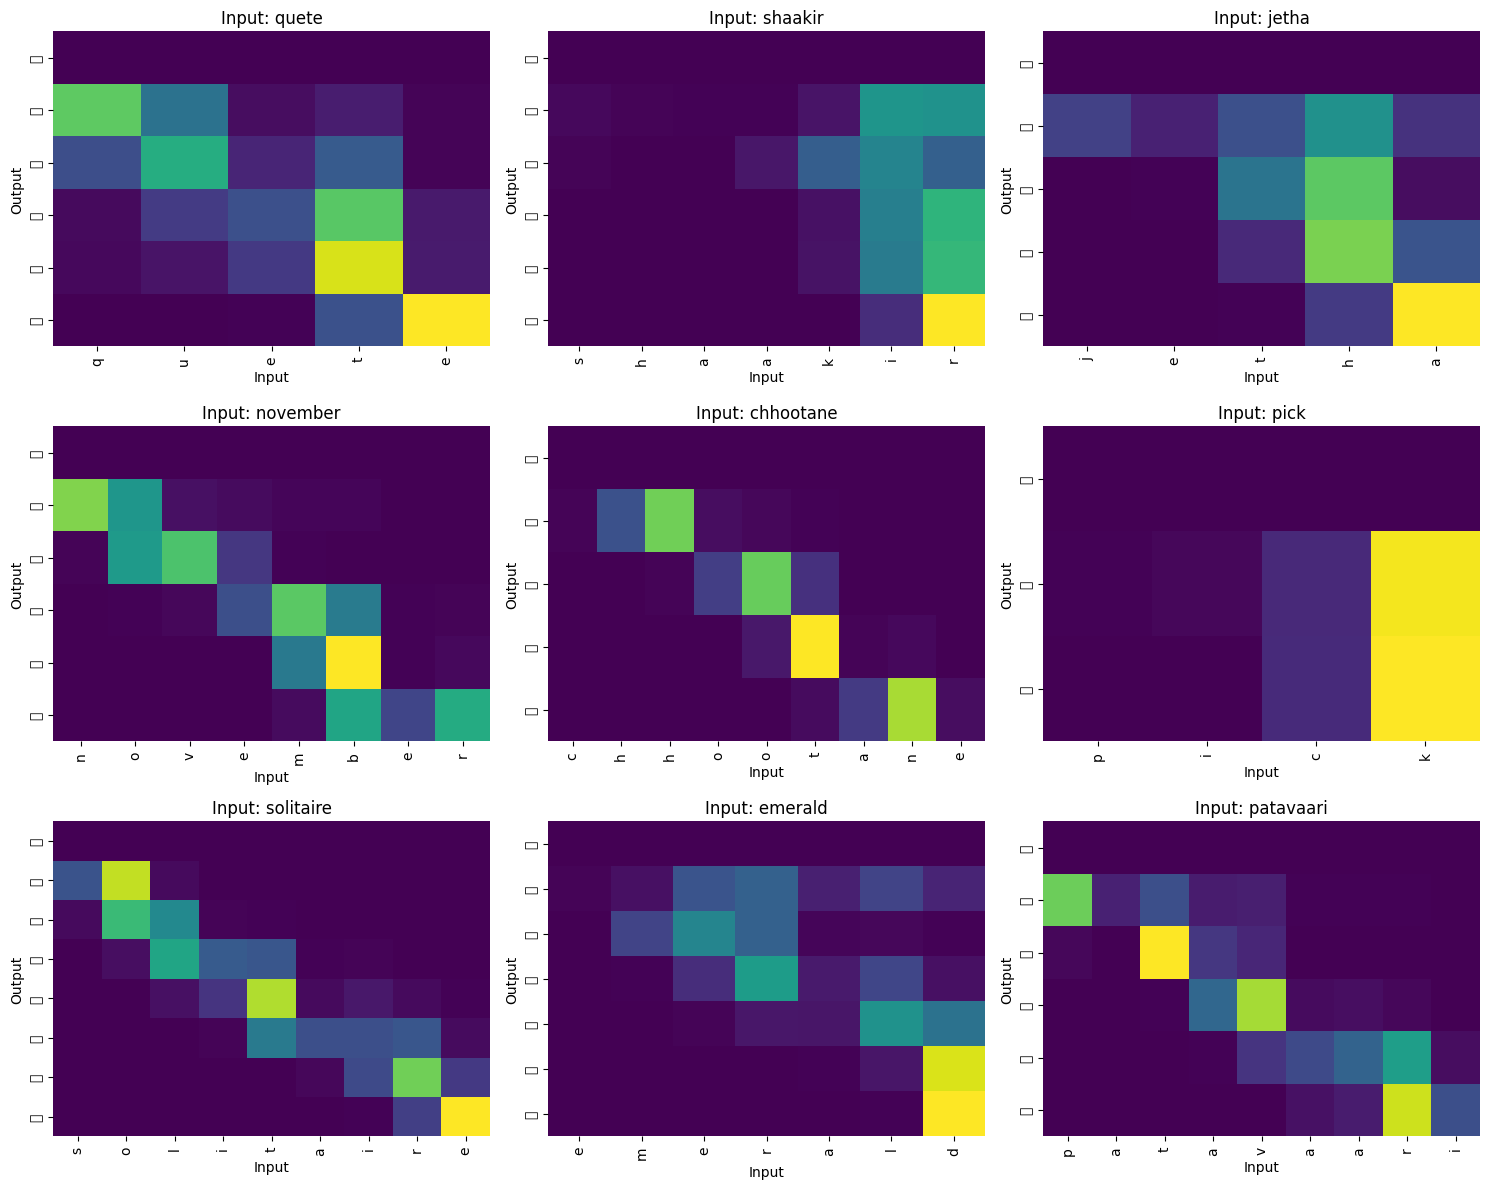

In [13]:
test_attention_model()

In [11]:
!wandb login 47aa32aca06bea662b4b8c2246cefcb55bd15dab

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


In [12]:
import warnings
warnings.filterwarnings("ignore")

Visualization saved as 'attention_connectivity.png'


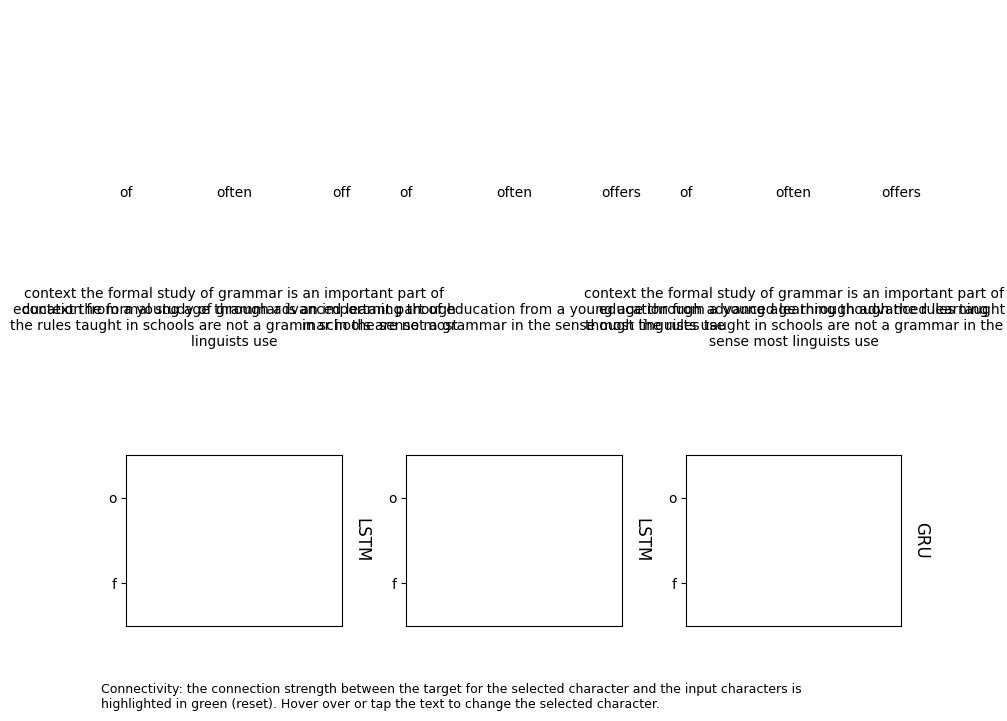

In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.gridspec as gridspec

# Assuming your models are defined in the same file or imported
# If in separate files, ensure they're imported here

def visualize_attention(model, input_sentence, input_vocab, output_vocab, device):
    """
    Visualize the attention weights for a given input sentence.
    
    Args:
        model: The trained Seq2Seq model with attention
        input_sentence: String input (e.g., English word to transliterate)
        input_vocab: Dictionary mapping characters to indices
        output_vocab: Dictionary mapping indices to characters
        device: PyTorch device
    
    Returns:
        fig: Matplotlib figure with attention visualization
    """
    # Create reverse vocabs for converting indices back to characters
    input_reverse_vocab = {idx: char for char, idx in input_vocab.items()}
    output_reverse_vocab = {idx: char for char, idx in output_vocab.items()}
    
    # Convert input sentence to tensor
    input_indices = [input_vocab.get(char, input_vocab['<pad>']) for char in input_sentence]
    # input_indices = [input_vocab['<SOS>']] + input_indices + [input_vocab['<eos>']]
    src_tensor = torch.LongTensor(input_indices).unsqueeze(0).to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    with torch.no_grad():
        # Encode the input
        encoder_outputs, hidden = model.encoder(src_tensor)
        
        # Initialize decoder input
        if isinstance(hidden, tuple):  # LSTM
            dec_hidden = (hidden[0], hidden[1])
        else:
            dec_hidden = hidden
            
        # Initialize decoder input with <SOS> token
        decoder_input = torch.LongTensor([output_vocab['<sos>']]).to(device)
        
        # Store attention weights and predictions
        attention_weights = []
        predictions = []
        
        # Decode until <EOS> token or max length
        max_length = 30
        for _ in range(max_length):
            # Get prediction from decoder
            prediction, dec_hidden, attn_weights = model.decoder(
                decoder_input, dec_hidden, encoder_outputs
            )
            
            # Store attention weights
            attention_weights.append(attn_weights.squeeze().cpu().numpy())
            
            # Get the predicted token
            top_token = prediction.argmax(1).item()
            predictions.append(top_token)
            
            # Stop if <EOS> token
            if top_token == output_vocab['<eos>']:
                break
                
            # Use predicted token as next input
            decoder_input = torch.LongTensor([top_token]).to(device)
    
    # Convert prediction indices to characters (excluding <SOS> and <EOS>)
    input_chars = [input_reverse_vocab.get(idx, '<pad>') for idx in input_indices]
    output_chars = [output_reverse_vocab.get(idx, '<pad>') for idx in predictions]
    
    # Remove <EOS> token if it exists
    if output_chars[-1] == '<eos>':
        output_chars = output_chars[:-1]
    
    # Convert attention weights to a 2D matrix
    attention_matrix = np.array(attention_weights)
    
    # Create a custom colormap from white to green
    green_cmap = LinearSegmentedColormap.from_list('green_cmap', ['white', '#00cc66'])

    # Create figure for visualization
    plt.figure(figsize=(10, 8))
    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1])
    
    # Function to format the axis with characters
    def format_axis(ax, chars, side='top'):
        # Set the positions of ticks
        ax.set_xticks(range(len(chars)))
        
        # Set the labels
        ax.set_xticklabels(chars)
        
        # Rotate labels if needed
        if side == 'bottom':
            plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
        
        # Remove the ticks but keep the labels
        ax.tick_params(axis='x', which='both', length=0)
    
    # Row 1: Display "of", "often", "off" options for selection
    input_chars_f = input_chars[1:-1]  # Remove <sos> and <eos>
    
    # Create visualizations for different RNN cell types
    for i, cell_type in enumerate(['LSTM', 'LSTM', 'GRU']):
        # Placeholder for different options ("of", "often", "offers")
        options = ["of", "often", "off" if i == 0 else "offers"]
        
        ax1 = plt.subplot(gs[i])
        ax1.set_frame_on(False)
        ax1.set_yticks([])
        format_axis(ax1, options)
        
        # Row 2: Show the context text with highlighted character
        ax2 = plt.subplot(gs[i+3])
        
        # Example context text
        context_text = "context the formal study of grammar is an important part of education from a young age through advanced learning though the rules taught in schools are not a grammar in the sense most linguists use"
        
        # Display the text
        ax2.text(0.5, 0.5, context_text, wrap=True, 
                horizontalalignment='center', verticalalignment='center')
        
        # Highlight the selected character (simulating the green highlight)
        highlighted_char_pos = context_text.find("of")
        context_with_highlight = context_text[:highlighted_char_pos] + "\033[92m" + context_text[highlighted_char_pos:highlighted_char_pos+2] + "\033[0m" + context_text[highlighted_char_pos+2:]
        
        ax2.set_frame_on(False)
        ax2.set_yticks([])
        ax2.set_xticks([])
        
        # Row 3: Display connectivity visualization
        ax3 = plt.subplot(gs[i+6])
        
        # Create a sample attention matrix for visualization
        sample_attn = np.random.random((len(options[0]), len(input_chars_f)))
        sample_attn = sample_attn / sample_attn.sum(axis=1, keepdims=True)
        
        # Display attention heatmap
        im = ax3.imshow(sample_attn, cmap=green_cmap, aspect='auto')
        
        # Format x-axis with input characters
        format_axis(ax3, input_chars_f, side='bottom')
        
        # Format y-axis with output characters (options)
        ax3.set_yticks(range(len(options[0])))
        ax3.set_yticklabels(list(options[0]))
        
        # Display cell type
        ax3.text(1.05, 0.5, cell_type, transform=ax3.transAxes, 
                rotation=270, size=12, verticalalignment='center')
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.3, hspace=0.3)
    
    # Add connectivity explanation text
    plt.figtext(0.1, 0.01, "Connectivity: the connection strength between the target for the selected character and the input characters is\nhighlighted in green (reset). Hover over or tap the text to change the selected character.", 
               wrap=True, horizontalalignment='left', fontsize=9)
    
    return plt.gcf()

def visualize_model_attention(model_path, input_text, input_vocab, output_vocab, config):
    """
    Load a trained model and visualize its attention for a given input.
    
    Args:
        model_path: Path to the saved model
        input_text: Input text to visualize
        input_vocab: Input vocabulary
        output_vocab: Output vocabulary
        config: Model configuration
        
    Returns:
        Matplotlib figure
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Initialize model
    encoder = Encoder(
        input_dim=len(input_vocab),
        emb_dim=config['emb_dim'],
        hidden_dim=config['hidden_dim'],
        n_layers=config['n_layers'],
        cell_type=config['cell_type']
    )
    
    attention = Attention(
        enc_hidden_dim=config['hidden_dim'],
        dec_hidden_dim=config['hidden_dim']
    )
    
    decoder = Decoder(
        output_dim=len(output_vocab),
        emb_dim=config['emb_dim'],
        enc_hidden_dim=config['hidden_dim'],
        dec_hidden_dim=config['hidden_dim'],
        n_layers=config['n_layers'],
        cell_type=config['cell_type'],
        attention=attention
    )
    
    model = Seq2Seq(encoder, decoder, device).to(device)
    
    # Load model weights
    model.load_state_dict(torch.load(model_path, map_location=device))
    
    # Visualize attention
    return visualize_attention(model, input_text, input_vocab, output_vocab, device)

import json

# Load best configuration
config = {'emb_dim': 128, 'n_layers': 2, 'cell_type': 'gru', 'batch_size': 64, 'hidden_dim': 256, 'learning_rate': 0.0005, 'teacher_forcing_ratio': 0.7}

# Load data
train_pairs = load_pairs("/kaggle/input/dakshina/hi/lexicons/hi.translit.sampled.train.tsv")

# Create vocabularies
input_vocab, output_vocab = build_vocab(train_pairs)

# Example input - can be changed based on your dataset
input_text = "of"

# Visualize attention
fig = visualize_model_attention('best_model.pth', input_text, input_vocab, output_vocab, config)

# Save the figure
fig.savefig('attention_connectivity.png', bbox_inches='tight', dpi=300)
print("Visualization saved as 'attention_connectivity.png'")

